In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

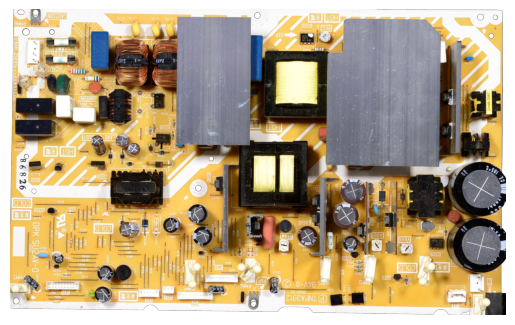

In [3]:
image = plt.imread('test.png')
plt.imshow(image)
plt.axis('off')
plt.show()

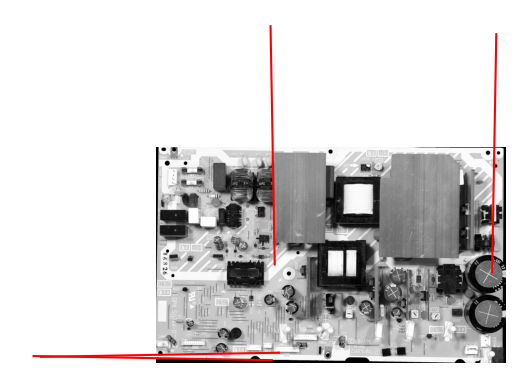

In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
gray = (255 * gray).astype(np.uint8)
bi = cv2.bilateralFilter(gray, 5, 75, 75)
edges = cv2.Canny(bi, 50, 150)
lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

min_x0 = (np.inf, np.inf, np.inf, np.inf)
min_y0 = (np.inf, np.inf, np.inf, np.inf)
max_x0 = (-np.inf, -np.inf, -np.inf, -np.inf)
max_y0 = (-np.inf, -np.inf, -np.inf, -np.inf)
for rho, theta in lines[:, 0]:
    # only keep approximately horizontal or vertical lines
    prec = 140
    is_horizontal = theta < np.pi / prec or theta > (prec - 1) * np.pi / prec
    is_vertical = (theta > (prec // 2 - 1) * np.pi / prec and theta < (prec // 2 + 1) * np.pi / prec)
    if not is_horizontal and not is_vertical:
        continue

    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho

    # only keep lines inside the image
    # if x0 < 0 or x0 > image.shape[1] or y0 < 0 or y0 > image.shape[0]:
    #     continue

    if x0 > max_x0[2] and is_vertical:
        max_x0 = (a, b, x0, y0)
    if y0 > max_y0[3] and is_horizontal:
        max_y0 = (a, b, x0, y0)
    if x0 < min_x0[2] and is_vertical:
        min_x0 = (a, b, x0, y0)
    if y0 < min_y0[3] and is_horizontal:
        min_y0 = (a, b, x0, y0)

plt.imshow(gray, cmap='gray')
for a, b, x0, y0 in [max_x0, max_y0, min_x0, min_y0]:
    if a == np.inf or a == -np.inf:
        continue
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    plt.plot((x1, x2), (y1, y2), 'r')

plt.axis('off')
plt.show()

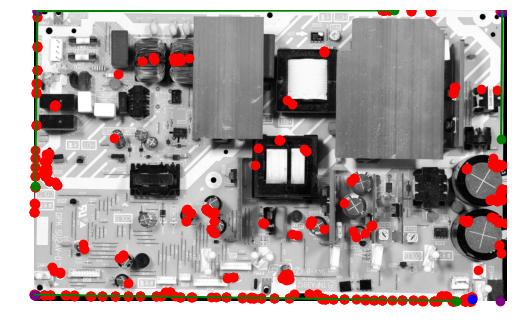

In [7]:
gray = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
gray = (255 * gray).astype(np.uint8)
bi = cv2.bilateralFilter(gray, 5, 75, 75)

dst = cv2.cornerHarris(bi, 2, 3, 0.04)
mask = np.zeros_like(bi)
mask[dst>0.01*dst.max()] = 255
coordinates = np.argwhere(mask)

def distance(pt1, pt2):
    (x1, y1), (x2, y2) = pt1, pt2
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def distance_to_line(pt, line):
    (x1, y1) = pt
    (x0, y0, a, b) = line
    return abs(a * (y0 - y1) - b * (x0 - x1))

def distance_to_line_pts(pt, line):
    (x, y) = pt
    (x1, y1), (x2, y2) = line
    return abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

coordinates = [tuple(pt.tolist()) for pt in coordinates]
coordinates = [(x, y) for y, x in coordinates]

# find the coordinates closest to the corners of the image (in clockwise order)
c1 = sorted(coordinates, key=lambda x: distance(x, (0, 0)))[0]
c2 = sorted(coordinates, key=lambda x: distance(x, (gray.shape[1], 0)))[0]
c3 = sorted(coordinates, key=lambda x: distance(x, (gray.shape[1], gray.shape[0])))[0]
c4 = sorted(coordinates, key=lambda x: distance(x, (0, gray.shape[0])))[0]
corner_coords = [c1, c2, c3, c4]

# find the coordinates closest to the edges of the image
samp = 30
top = sorted(coordinates, key=lambda x: distance_to_line(x, (0, 0, 1, 0)))[:samp]
bottom = sorted(coordinates, key=lambda x: distance_to_line(x, (0, gray.shape[0], 1, 0)))[:samp]
left = sorted(coordinates, key=lambda x: distance_to_line(x, (0, 0, 0, 1)))[:samp]
right = sorted(coordinates, key=lambda x: distance_to_line(x, (gray.shape[1], 0, 0, 1)))[:samp]
edge_lines = [top, right, bottom, left]
# average the coordinates
average_edge_coords = [tuple(np.mean(e, axis=0)) for e in edge_lines]
# find the best fit line
lines = []
for origin, endpoints, points in zip(average_edge_coords, [(c1, c2), (c2, c3), (c3, c4), (c4, c1)], edge_lines):
    candidates = []
    for pt in endpoints:
        candidates.append((origin, pt))
    best_candidate = min(candidates, key=lambda x: np.sum([distance_to_line_pts(pt, x) for pt in points]))
    lines.append(best_candidate)
# find line intersections
true_corner_coords = []
for i in range(len(lines)):
    (x1, y1), (x2, y2) = lines[i]
    (x3, y3), (x4, y4) = lines[(i + 1) % len(lines)]
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    x = (x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)
    x /= denom
    y = (x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)
    y /= denom
    true_corner_coords.append((x, y))
true_corner_coords = true_corner_coords[-1:] + true_corner_coords[:-1]

plt.imshow(gray, cmap='gray')
plt.scatter(*zip(*coordinates), c='red')
plt.scatter(*zip(*corner_coords), c='blue')
plt.scatter(*zip(*average_edge_coords), c='green')
for (x1, y1), (x2, y2) in lines:
    plt.plot((x1, x2), (y1, y2), 'green')
plt.scatter(*zip(*true_corner_coords), c='purple')
plt.axis('off')
plt.show()

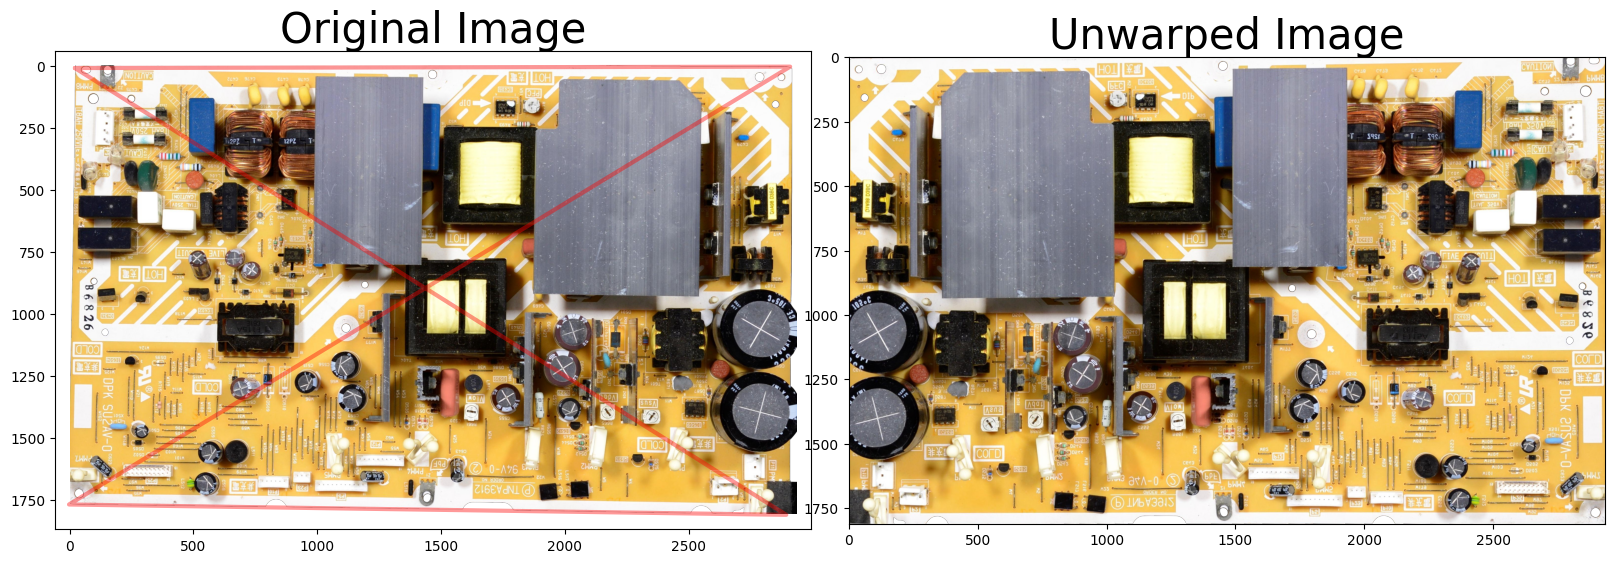

In [9]:
h, w = image.shape[0], image.shape[1]
src = np.array(true_corner_coords, dtype=np.float32)
dst = np.array([(0, 0), (w, 0), (w, h), (0, h)], dtype=np.float32)
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(image, M, (w, h), flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.subplots_adjust(hspace=.2, wspace=.05)
ax1.imshow(image)
x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h + 60, -60])
ax1.set_xlim([-60, w + 60])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.flip(warped, 1))
ax2.set_title('Unwarped Image', fontsize=30)
plt.show()